In [40]:
import numpy as np
import scipy.linalg as lin
import matplotlib.pyplot as plt
import scipy.stats as sps

# Troisième cas : Estimation naive

$ I_0=10, \alpha_i=10, \beta_i=5 $ pour $i \in [1,5]$ et $\alpha_i=-10, \beta_i=-5 $ pour $i \in [6,10]$

## Preset :

In [41]:
T0,T,Y=120,10,252

alpha=1-1e-4
I0=10
sigma = np.array([0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7]) #yearly std
S0=np.array([500,400,300,200,100,50,40,30,20,10])
K=np.array([510,390,310,190,90,55,35,34,17,12])
n=2*int(1e4)

coeffC=np.array([10 for k in range(5)]+[-10 for k in range(5)])
coeffP=np.array([5 for k in range(5)]+[-5 for k in range(5)])

In [42]:
def d1(to,x,y,sig):
    return np.log(x/y)/(sig*np.sqrt(to)) + sig*np.sqrt(to)/2
def d2(to,x,y,sig):
    return np.log(x/y)/(sig*np.sqrt(to)) - sig*np.sqrt(to)/2


def callPrice(S,t,K,sigma,T):
    return S*sps.norm.cdf(d1((T-t)/Y,S,K,sigma))-K*sps.norm.cdf(d2((T-t)/Y,S,K,sigma))
def putPrice(S,t,K,sigma,T):
    return K*sps.norm.cdf(d1((T-t)/Y,K,S,sigma))-S*sps.norm.cdf(d2((T-t)/Y,K,S,sigma))

In [43]:
def dCall(S,t,K,sigma,T):
  return sps.norm.cdf(d1((T-t)/Y,S,K,sigma))+sps.norm.pdf(d1((T-t)/Y,S,K,sigma))/(sigma*np.sqrt((T-t)/Y))-K*sps.norm.pdf(d2((T-t)/Y,S,K,sigma))/(sigma*np.sqrt((T-t)/Y)*S)
def hedgedCallPrice(S,t,K,sigma,T,S0):
  return callPrice(S,t,K,sigma,T)-dCall(S0,0,K,sigma,T)*S

def dPut(S,t,K,sigma,T):
  return -sps.norm.cdf(d2((T-t)/Y,K,S,sigma))+sps.norm.pdf(d2((T-t)/Y,K,S,sigma))/(sigma*np.sqrt((T-t)/Y))-K*sps.norm.pdf(d1((T-t)/Y,K,S,sigma))/(sigma*np.sqrt((T-t)/Y)*S)
def hedgedPutPrice(S,t,K,sigma,T,S0):
  return putPrice(S,t,K,sigma,T)-dPut(S0,0,K,sigma,T)*S

In [44]:
#Greeks
#for a call:
def thetaC(S0,K,sigma,T,T0):
    return -S0*sigma*sps.norm.pdf(d1((T0-T)/Y,S0,K,sigma))/(2*np.sqrt((T0-T)/Y))
def deltaC(S0,K,sigma,T,T0):
    return sps.norm.cdf(d1((T0-T)/Y,S0,K,sigma))
def gammaC(S0,K,sigma,T,T0):
    return sps.norm.pdf(d1((T0-T)/Y,K,S0,sigma))/(sigma*S0*np.sqrt((T0-T)/Y))

#for a put:
def thetaP(S0,K,sigma,T,T0):
    return -S0*sigma*sps.norm.pdf(d1((T0-T)/Y,S0,K,sigma))/(2*np.sqrt((T0-T)/Y))
def deltaP(S0,K,sigma,T,T0):
    return sps.norm.cdf(d1((T0-T)/Y,K,S0,sigma))-1
def gammaP(S0,K,sigma,T,T0):
    return sps.norm.pdf(d1((T0-T)/Y,K,S0,sigma))/(sigma*S0*np.sqrt((T0-T)/Y))


In [45]:
C=np.diag(sigma*np.sqrt(T/Y)*S0)
delta=coeffC*deltaC(S0,K,sigma,T,T0)+coeffP*deltaP(S0,K,sigma,T,T0)
deltaH=delta-coeffC*dCall(S0,0,K,sigma,T0)-coeffP*dPut(S0,0,K,sigma,T0)
Theta=np.dot(coeffC.T,thetaC(S0,K,sigma,T,T0))+np.dot(coeffP.T,thetaP(S0,K,sigma,T,T0))

In [46]:
def estimVaR(L):
  a=-Theta*T/Y
  b=-np.dot(L.T,np.dot(C.T,delta))
  
  z=sps.norm.ppf(alpha)
  return a+lin.norm(b)*z

def estimVaRHedged(L):
  a=-Theta*T/Y
  b=-np.dot(L.T,np.dot(C,deltaH))
  
  z=sps.norm.ppf(alpha)
  return a+lin.norm(b)*z

In [47]:
Si=np.zeros((n,I0))
MatSigma=np.zeros((n,I0))
MatK=np.zeros((n,I0)) 
for i in range(I0):
  Si[:,i]+=S0[i]
  MatK[:,i]+=K[i]
  MatSigma[:,i]+=sigma[i]

[]

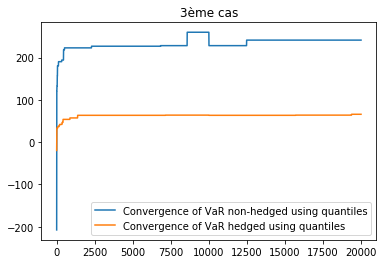

In [52]:
def position(l,k):
    a,b=0,k
    i=k
    while(b-a>0):
        if(b-a==1):
            if(l[k]>=l[a]): i=b
            else : i=a
            b=a
        else :
            mi=int(a+(b-a)/2)
            if(l[mi]<l[k]): a=mi
            elif(l[mi]>l[k]) : b=mi
            else :
                i=mi
                b=a
    return i

Z=np.random.normal(size=(n,T,I0)) 
logIncr2=np.zeros((n,T,I0))
for t in range(T):
    logIncr2[:,t,:]=-MatSigma*MatSigma/(2*Y)+MatSigma/np.sqrt(Y)*Z[:,t,:]
logS=np.cumsum(logIncr2,axis=1)
Sf=np.zeros((n,I0))
for j in range(I0):
    Sf[:,j]=S0[j]*np.exp(logS[:,T-1,j])

calls=callPrice(Sf,T,MatK,MatSigma,T0)
puts=putPrice(Sf,T,MatK,MatSigma,T0)

callInitial=callPrice(Si,0,MatK,MatSigma,T0)
putInitial=putPrice(Si,0,MatK,MatSigma,T0)

deltaCall=callInitial-calls
deltaPut=putInitial-puts

loss1=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
values1=[]
for k in range(1,n):
    i=position(loss1,k)
    loss1[:k+1]=np.concatenate((loss1[:i],np.array(loss1[k]),loss1[i:k]), axis=None)
    values1.append(loss1[int(alpha*k)])
plt.plot(np.arange(1,len(values1)+1),values1, label='Convergence of VaR non-hedged using quantiles')

calls=hedgedCallPrice(Sf,T,MatK,MatSigma,T0,Si)
puts=hedgedPutPrice(Sf,T,MatK,MatSigma,T0,Si)

callInitial=hedgedCallPrice(Si,0,MatK,MatSigma,T0,Si)
putInitial=hedgedPutPrice(Si,0,MatK,MatSigma,T0,Si)

deltaCall=callInitial-calls
deltaPut=putInitial-puts

loss2=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
    
values2=[]
for k in range(1,n):
    i=position(loss2,k)
    loss2[:k+1]=np.concatenate((loss2[:i],np.array(loss2[k]),loss2[i:k]), axis=None)
    values2.append(loss2[int(alpha*k)])
plt.plot(np.arange(1,len(values2)+1),values2,label='Convergence of VaR hedged using quantiles')
plt.legend(loc='best')
plt.title("3ème cas")
plt.plot()

[]

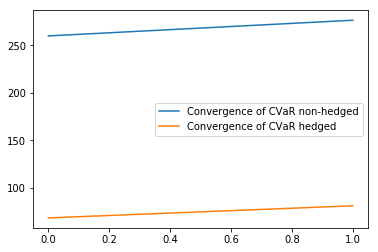

In [55]:
cond1=loss1[loss1>=loss1[int(alpha*n)]]

cvarValues1=[]
for k in range(len(cond1)):
    cvarValues1.append(cond1[:k])

cond2=loss2[loss2>=loss2[int(alpha*n)]]

cvarValues2=[]
for k in range(len(cond2)):
    cvarValues2.append(cond2[:k])
    
    
cvarValues1=np.array(cvarValues1)/(1-alpha) + loss1[int(alpha*n)]
cvarValues2=np.array(cvarValues2)/(1-alpha) + loss2[int(alpha*n)]


plt.plot(cond1,label='Convergence of CVaR non-hedged' )
plt.plot(cond2,label='Convergence of CVaR hedged' )
plt.legend(loc='best')
plt.plot()